# Imports

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
import numpy as np

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

# 1. Load and concatenate splitted dataset

In [2]:
dataset = load_dataset('gnad10')
df_train = dataset['train']
df_test = dataset['test']
df = pd.concat([pd.DataFrame(df_train), pd.DataFrame(df_test)], axis=0)

Found cached dataset gnad10 (C:/Users/tomas/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881)


  0%|          | 0/2 [00:00<?, ?it/s]

# 2. Remove stopwords, tokenize and pad text sequences

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
text_tokens = [word_tokenize(text) for text in tqdm(df['text'], desc='Train tokenization')]

Train tokenization: 100%|██████████| 10273/10273 [00:46<00:00, 220.29it/s]


In [5]:
text_filtered = [[token for token in text if token.lower() not in stop_words] for text in tqdm(text_tokens, desc='Removing stop words')]

Removing stop words: 100%|██████████| 10273/10273 [00:01<00:00, 9321.01it/s]


In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_filtered)
text_tokenized = tokenizer.texts_to_sequences(text_filtered)

In [7]:
length = [len(token_list) for token_list in text_tokenized]
print(max(length))
SEQUENCE_LENGTH = int(np.quantile(length, 0.75))
SEQUENCE_LENGTH

3163


342

In [8]:
text_padded = pad_sequences(text_tokenized, maxlen=1250) # SEQUENCE_LENGTH

# 3. Split dataframe into train and test subsets

In [9]:
X_train, x_test, y_train, y_test = train_test_split(text_padded, df['label'], test_size=0.2, stratify=df['label'])

# 4. Get class weights

In [10]:
class_counts = Counter(y_train)
samples = sum(class_counts.values())
class_weights = {}
for label, count in class_counts.items():
    class_weights[label] = (1 / count) * (samples / len(class_counts))

print(f'class weights:\n {class_weights}')

class weights:
 {2: 0.7552614649388842, 3: 0.8087786635173704, 1: 0.6804106640172214, 4: 0.9501676494392416, 0: 0.6804106640172214, 8: 2.1185872647589585, 7: 1.9936923823386703, 5: 1.1245210727969348, 6: 1.709945900957137}


# 5. Apply *SMOTE* on train data (optional)

`smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)`

In [11]:
print(f'shape of train texts: {X_train.shape}\n'
      f'shape of train labels: {y_train.shape}\n'
      f'shape of test texts: {x_test.shape}\n'
      f'shape of test labels: {y_test.shape}')

shape of train texts: (8218, 1250)
shape of train labels: (8218,)
shape of test texts: (2055, 1250)
shape of test labels: (2055,)


# 6. Define the model

In [12]:
VOCAB_LENGTH = len(tokenizer.word_index) + 1
VECTOR_SIZE = 100

def get_model():

      model = keras.Sequential()
      model.add(layers.Embedding(input_dim=VOCAB_LENGTH, output_dim=VECTOR_SIZE, input_length=1250))

      model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dense(256, activation='relu'))
      model.add(layers.Dropout(0.5))

      model.add(layers.Dense(9, activation='softmax'))
      model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

      return model

In [13]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 100)         22666300  
                                                                 
 conv1d (Conv1D)             (None, 1248, 128)         38528     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                        

# 7. Train the model, get metrics

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=2, mode='min')

In [15]:
history = model.fit(X_train, y_train, validation_data=(x_test, y_test), epochs=10, callbacks=[early_stop], class_weight=class_weights)

Epoch 1/10
257/257 [==============================] - 140s 539ms/step - loss: 1.8085 - accuracy: 0.3608 - val_loss: 0.9739 - val_accuracy: 0.6891
Epoch 2/10
257/257 [==============================] - 120s 467ms/step - loss: 0.7244 - accuracy: 0.7768 - val_loss: 0.6669 - val_accuracy: 0.7810
Epoch 3/10
257/257 [==============================] - 116s 451ms/step - loss: 0.1537 - accuracy: 0.9577 - val_loss: 0.5902 - val_accuracy: 0.8015
Epoch 4/10
257/257 [==============================] - 131s 511ms/step - loss: 0.0283 - accuracy: 0.9961 - val_loss: 0.6136 - val_accuracy: 0.8112
Epoch 5/10
257/257 [==============================] - 131s 510ms/step - loss: 0.0088 - accuracy: 0.9995 - val_loss: 0.6161 - val_accuracy: 0.8165
Epoch 5: early stopping


# 8. Visualize metrics

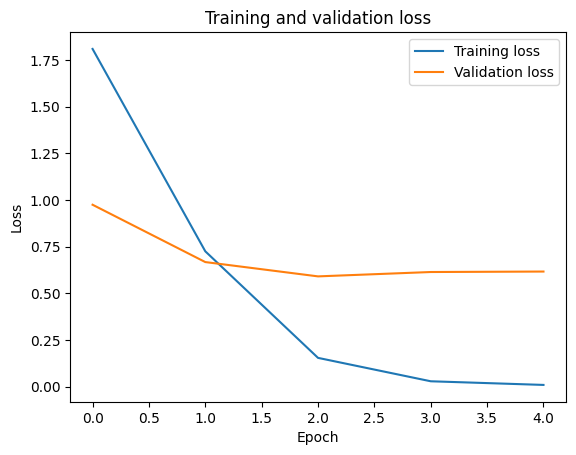

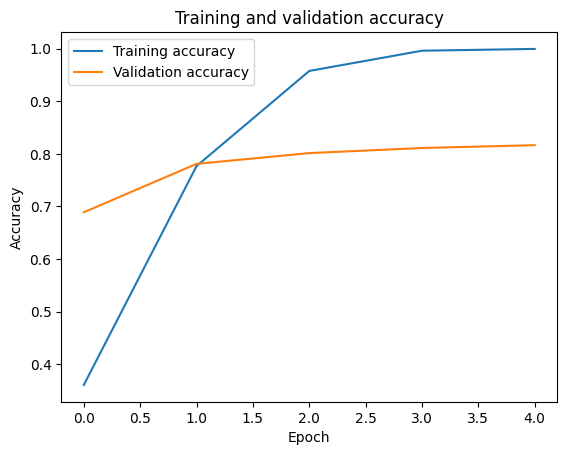

In [16]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels if needed

# Convert the labels to numpy arrays if they are not already
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

65/65 [==============================] - 4s 55ms/step
[[288   4  14  14   1   4   9   1   0]
 [  0 263  13  10   2  33   4   4   7]
 [  2  20 254  13   1   1   9   1   1]
 [ 11  20   9 215   5  19   1   2   0]
 [  0   6   1   0 227   1   2   0   3]
 [  1  26   1  15   0 151   1   5   3]
 [  5   6   4   4   1   7  99   0   8]
 [  0   5   1   0   0   2   2  97   8]
 [  3   8   0   1   1   2   5   4  84]]


* True distribution:
[(0, 335),
 (1, 336),
 (2, 302),
 (3, 282),
 (4, 240),
 (5, 203),
 (6, 134),
 (7, 115),
 (8, 108)]